<a href="https://colab.research.google.com/github/ernestomancebo/DeepLearningInPractice/blob/main/transfer_learning/transfer_learning_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning - Feature Extraction

In this notebook we're doing a Cat/Dog classifier using a pre-trained VGG16 model. Such model is a 5-block ConvNet and trained with more than a million of images of over 1K classes. That said, this base model can catch better representations/features than any model trained with few examples.


To pick the advantages of the feature mapping and all the representations of such model, we're freezing the `Conv2D` and `MaxPool` layers, then stacking `Dense` layers, so we train the classifier on top of the output of it.


There're two approaches to do *Transfer Learning*: **Feature Extraction** and **Fine Tunning**, in this notebook we're applying **Feature Extraction** and what it does is the mentioned in the parragraph above. A **Fine Tunning** Notebook must be present along wiht this notebook.

This notebook uses the `Cat and Dog` dataset from Kaggle.

In [1]:
!pip install kaggle kaggle-cli

     |████████████████████████████████| 81kB 7.3MB/s 
     |████████████████████████████████| 5.3MB 19.1MB/s 
     |████████████████████████████████| 112kB 59.7MB/s 
     |████████████████████████████████| 133kB 63.0MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
  Created wheel for kaggle-cli: filename=kaggle_cli-0.12.13-cp36-none-any.whl size=9489 sha256=510bc20f0426237a2a49f75386e7a4b60b692a9c919ed93049edbd8c3e08f715
  Stored in directory: /root/.cache/pip/wheels/d5/bb/10/c1dd1b08c7433c943cb55c46367ae3f891415e8a37300ff8a7
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=eab14f784bb248f93913d80df3b8760ee1afc1506fb4534aa2c3b9e3885711fa
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Created wheel for pyperclip: filename=pyperclip-1.8.1-cp36-none-any.whl size=11120 sha256=ca26570374946510c61f66716618c8df237faa9868d33c61a0f4d87d2e5cc62e
  Stored in directory: /root/.ca

In [2]:
from google.colab import files
out = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [1]:
!touch __ini__.py
!curl -O https://raw.githubusercontent.com/ernestomancebo/DeepLearningInPractice/main/transfer_learning/dataset_init.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2650  100  2650    0     0  17666      0 --:--:-- --:--:-- --:--:-- 17666


In [4]:
!kaggle competitions download -c dogs-vs-cats -p kaggle_original_data

 95% 258M/271M [00:01<00:00, 233MB/s]
100% 271M/271M [00:01<00:00, 228MB/s]
 99% 538M/543M [00:02<00:00, 218MB/s]
100% 543M/543M [00:02<00:00, 251MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 87.0MB/s]


In [5]:
from dataset_init import set_up_cat_dogs_small_dataset

# this sets up our training dataset
directories =  set_up_cat_dogs_small_dataset()

#VGG16 - ImageNet

Now we load a pre-trained model, in specific the vgg16 pretrained with the ImageNet dataset

In [6]:
from keras.applications import VGG16

conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)
conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

##Extracting features
In this section we're going to extract features of our dataset using the pre-trained convnet, which later we plug such ouput to a classifier layer.

In [7]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      directory,
      target_size=(150, 150),
      batch_size=batch_size,
      class_mode='binary'
  )

  i = 0
  for input_batch, labels_batch in generator:
    # What we do here is to get from the convolution block the feaure output.
    # In other words, we get the convolutional representation.
    features_batch = conv_base.predict(input_batch)
    features[i * batch_size : (i + 1) *  batch_size] = features_batch
    labels[i * batch_size : (i + 1) *  batch_size] = labels_batch

    i += 1
    if i * batch_size >= sample_count:
      break
  
  return features, labels

The next lines can be executed way way faster in GPU.

In [8]:
train_features, train_labels = extract_features(directories['train'], 2000)
validation_features, validation_labels = extract_features(directories['validation'], 1000)
test_features, test_labels = extract_features(directories['test'], 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Now we push the `Dense` stack on top of the `Conv2D` and train it, but freezing the later.

In [9]:
# This is the output shape of the last layer of the VGG16 model
input_dimension_shape = 4 * 4 * 512

train_features = np.reshape(train_features, (2000, input_dimension_shape))
validation_features = np.reshape(validation_features, (1000, input_dimension_shape))
test_features = np.reshape(test_features, (1000, input_dimension_shape))

In [10]:
from keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=input_dimension_shape))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [11]:
%%capture
history = model.fit(
    train_features, train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels)
)

Here's another helper, this time a plot one.

In [12]:
!curl -O https://raw.githubusercontent.com/ernestomancebo/DeepLearningInPractice/main/transfer_learning/plot.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   830  100   830    0     0  12575      0 --:--:-- --:--:-- --:--:-- 12575


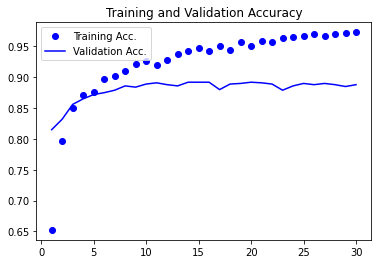

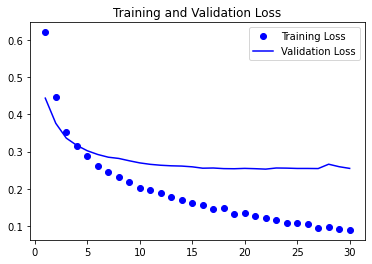

In [13]:
from plot import plot_trainig_results

plot_trainig_results(history)

The accuracy of the model didn't worked as good as we might wanted to, but we were able to apply feature extraction form one network and push it as input to another.

A better result would have be seen with more training data pushed into our `Dense` layers, remember that the trained `ConvNet` was already trained.